# Clustering on two different regions

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import seaborn as sns
import time

#Directly import what we need from aare
from aare import RawFile, ClusterFinderMT, ClusterFileSink, ClusterFile


path = Path('/mnt/sls_det_storage/highZ_data/JMulvey/For_Erik/m401_Cu8000eV')
pd_file = path/'250130_CZTboth_Pedestal_Tp_15C_tint_100_master_0.json'
data_file = path/'250130_CZTboth_Xray_Tp_15C_tint_100_master_0.json'

Example run on: **2025-02-12 14:15** with aare: **dev**

### JF module with ROI 256x1024

(256, 1024)


(3000.0, 9000.0)

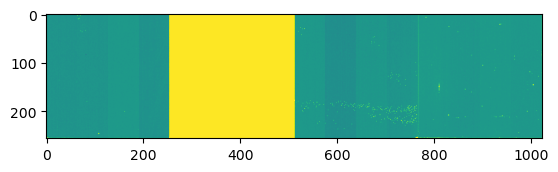

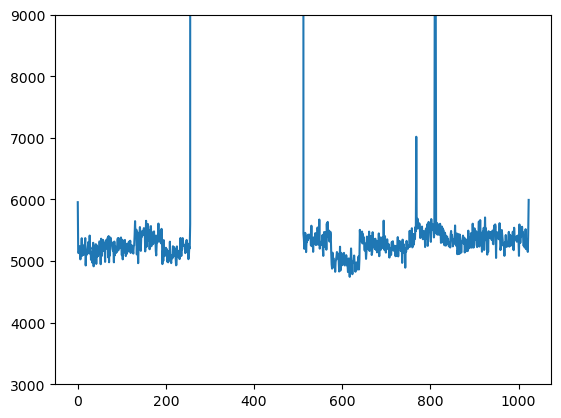

In [2]:
with RawFile(pd_file) as f:
    _, img = f.read_frame()
    
print(img.shape)

fig, ax = plt.subplots()
im = ax.imshow(img)
im.set_clim(0,10000)

fig, ax = plt.subplots()
ax.plot(img[150,:])
ax.set_ylim(3000,9000)

### Run clustering on the left and right chip

Initial pedestal took 0.646s


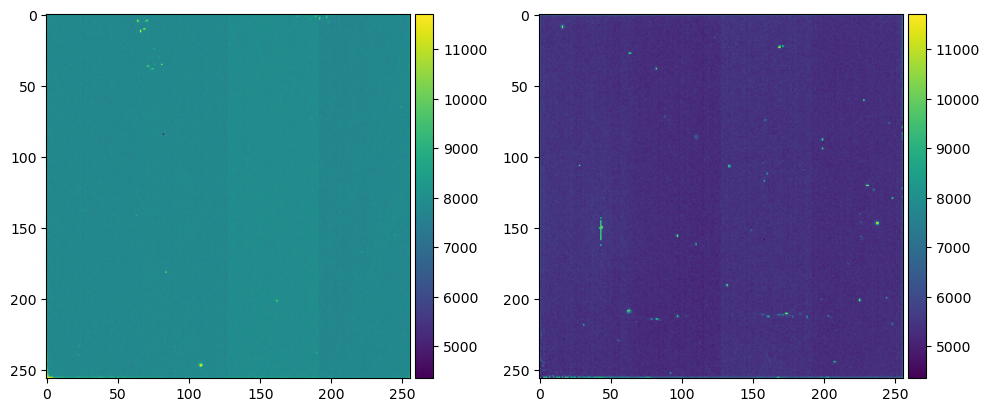

In [3]:
out_fname0 = path/'clusters/chip0.clust'
out_fname1 = path/'clusters/chip1.clust'

image_size = (256,256)
cluster_size = (3,3)
n_threads = 16

#ROIs for the two different chips
chip0 = (slice(0,256,1), slice(0,256,1))
chip1 = (slice(0,256,1), slice(768,1024,1))

cf0 = ClusterFinderMT(image_size, cluster_size, n_threads = n_threads)
cf1 = ClusterFinderMT(image_size, cluster_size, n_threads = n_threads)
sink0 = ClusterFileSink(cf0, out_fname0)
sink1 = ClusterFileSink(cf1, out_fname1)

t0 = time.perf_counter()
with RawFile(pd_file) as f:
    f.seek(1000)
    for i in range(1000):
        header, image = f.read_frame()
        cf0.push_pedestal_frame(image[chip0].copy())
        cf1.push_pedestal_frame(image[chip1].copy())
        
cf0.stop()
cf1.stop()
print(f'Initial pedestal took {time.perf_counter()-t0:.3f}s')
pd0 = cf0.pedestal(0)
pd1 = cf1.pedestal(0)
cf0.start()
cf1.start()

fig, axs = plt.subplots(1,2, figsize = (10,5))
im = axs[0].imshow(pd0)
im = axs[1].imshow(pd1)
for ax in axs:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
fig.tight_layout()

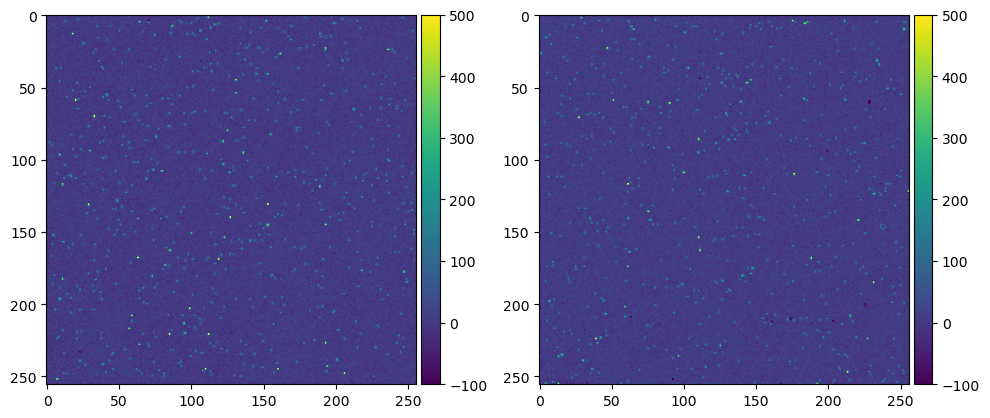

In [4]:
with RawFile(data_file) as f:
    f.seek(1000)
    _, img = f.read_frame()

    
clim = (-100,500)
fig, axs = plt.subplots(1,2, figsize = (10,5))
im = axs[0].imshow(img[chip0]-pd0)
im.set_clim(clim)
im = axs[1].imshow(img[chip1]-pd1)
im.set_clim(clim)
for ax in axs:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
fig.tight_layout()

In [5]:
N = 10000
t0 = time.perf_counter()
with RawFile(data_file) as f:
    for i in range(N):
        header, image = f.read_frame()
        cf0.find_clusters(image[chip0].copy(), header[0]['frameNumber'])
        cf1.find_clusters(image[chip1].copy(), header[0]['frameNumber'])
cf0.stop()
cf1.stop()
sink0.stop()
sink1.stop()
t_elapsed = time.perf_counter()-t0
print(f'Clustering (and writing to disk) {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')


Clustering (and writing to disk) 10000 frames took 2.42s  4131 FPS


Text(0.5, 1.0, 'Chip 0')

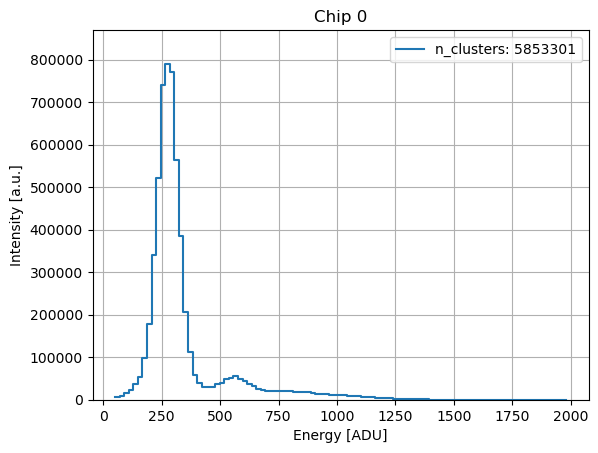

In [6]:
#one histogram with the sum for each cluster in the file
hist1 = bh.Histogram(bh.axis.Regular(100, 50, 2000))

with ClusterFile(out_fname0) as f:
    for clusters in f:
        hist1.fill(clusters.sum())
        

fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {hist1.sum():.0f}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()
ax.set_title('Chip 0')

5608956.0 clusters 560.8956 per frame


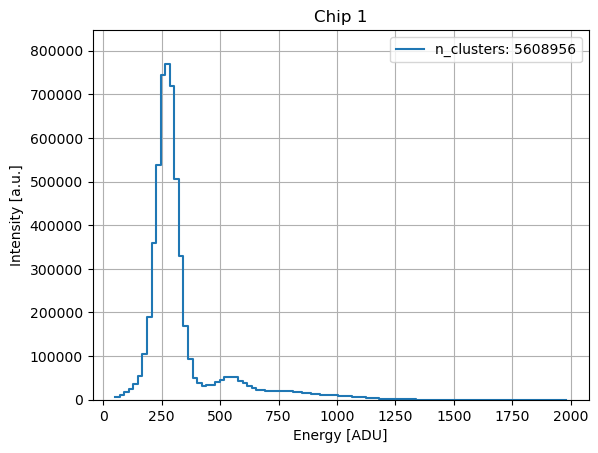

In [7]:
#one histogram with the sum for each cluster in the file
hist1 = bh.Histogram(bh.axis.Regular(100, 50, 2000))

with ClusterFile(out_fname1) as f:
    for clusters in f:
        hist1.fill(clusters.sum())
        

fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {hist1.sum():.0f}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()
ax.set_title('Chip 1')

print(f'{hist1.sum()} clusters {hist1.sum()/N} per frame')